In [2]:
from sklearn import preprocessing
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
import time
from collections import deque

df = pd.read_csv('data/BTC-USD.csv', names=['time', 'low', 'high', 'open', 'close', 'volume'])

df['time'] = pd.to_datetime(df['time'], unit='s')

print(df.head())

time          low         high         open        close  \
0 2018-06-14 09:31:00  6489.549805  6489.560059  6489.560059  6489.549805   
1 2018-06-14 09:32:00  6487.370117  6489.560059  6489.549805  6487.379883   
2 2018-06-14 09:33:00  6479.410156  6487.370117  6487.370117  6479.410156   
3 2018-06-14 09:34:00  6479.410156  6479.419922  6479.419922  6479.410156   
4 2018-06-14 09:35:00  6475.930176  6479.979980  6479.410156  6479.979980   

     volume  
0  0.587100  
1  7.706374  
2  3.088252  
3  1.404100  
4  0.753000  


Text(0.5, 1.0, 'BTC')

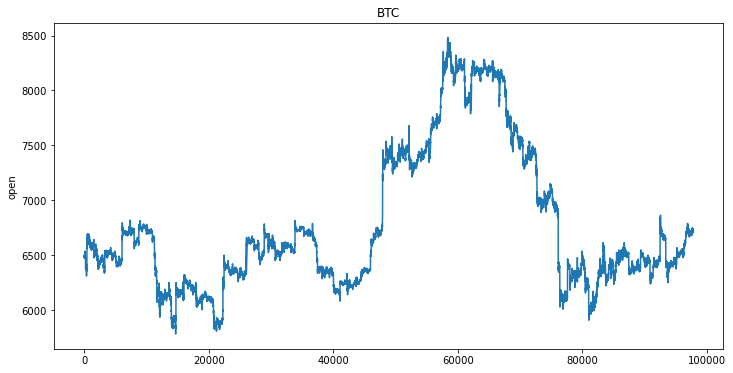

In [2]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='open', data=df).set_title('BTC')

In [3]:
df.set_index(pd.to_datetime(df['time'], unit='s'), inplace=True) 
df.index

DatetimeIndex(['2018-06-14 09:31:00', '2018-06-14 09:32:00',
               '2018-06-14 09:33:00', '2018-06-14 09:34:00',
               '2018-06-14 09:35:00', '2018-06-14 09:36:00',
               '2018-06-14 09:37:00', '2018-06-14 09:38:00',
               '2018-06-14 09:39:00', '2018-06-14 09:40:00',
               ...
               '2018-08-25 16:31:00', '2018-08-25 16:32:00',
               '2018-08-25 16:33:00', '2018-08-25 16:34:00',
               '2018-08-25 16:35:00', '2018-08-25 16:36:00',
               '2018-08-25 16:37:00', '2018-08-25 16:38:00',
               '2018-08-25 16:39:00', '2018-08-25 16:40:00'],
              dtype='datetime64[ns]', name='time', length=97724, freq=None)

Text(0.5, 1.0, 'BTC downsampled')

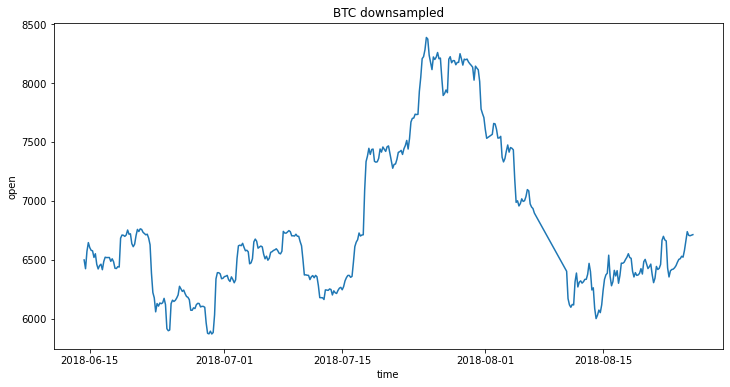

In [4]:
plt.figure(figsize=(12,6))
new_df = df.resample('4H').mean()
sns.lineplot(x=new_df.index, y='open', data=new_df).set_title('BTC downsampled')

In [5]:
sequence_length = 60
minutes_predict_period = 5
ratio_to_predict = 'BTC-USD'

# classify future prediction as buy or sell
def classify(current, future):
    if float(future) > float(current): 
            # if price goes up BUY
        return 1
 #   elif float(future) < float(current * 0.99):   # else SELL
 #       return 0
    else:
        return 0

In [6]:
def preprocess_df(df):
    df = df.drop("future", 1)  # don't want to tell network what the future price will be

    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] = df[col].pct_change()  # pct change "normalizes" the different currencies (each crypto coin has vastly diff values, we're really more interested in the other coin's movements)
            df.dropna(inplace=True)  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)

    sequential_data = []  # this is a list that will CONTAIN the sequences

    # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
    # like a circular buffer/queue
    prev_days = deque(maxlen=sequence_length)  

    for i in df.values: 
        prev_days.append([value for value in i[:-1]])  # store all but the target
        if len(prev_days) == sequence_length:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets
  #  do_nada = []

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!
      #  elif target == 2:
      #      do_nada.append([seq, target])

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!
  #  random.shuffle(do_nada)

    # balance buys and sells
    lower = min(len(buys), len(sells))  # what's the shorter length?
    buys = buys[:lower]  # make sure both lists are only up to the shortest length to have balance data
    sells = sells[:lower]
 #   do_nada = do_nada[:lower]

    sequential_data = buys+sells # +do_nada  # add them together
    random.shuffle(sequential_data)  # shuffle them so it's not only buys then only sells

    X = []
    y = []

    for seq, target in sequential_data: 
        X.append(seq)  # X is the sequences/features
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), y  # return features as numpy array

In [7]:
main_df = pd.DataFrame()

tickers = ['BTC-USD', 'LTC-USD', 'ETH-USD', 'BCH-USD']

for ticker in tickers:
    path = f"data/{ticker}.csv"

    df = pd.read_csv(path, names=['time', 'low', 'high', 'open', 'close', 'volume'])

    df.rename(columns={"close":f"{ticker}_close", "volume": f"{ticker}_volume"}, inplace=True)


    df.set_index(pd.to_datetime(df['time'], unit='s'), inplace=True) 

    df = df[[f"{ticker}_close", f"{ticker}_volume"]]
    df = df.resample('1H').mean()

    if len(main_df) ==0:
        main_df = df
    else:
        main_df = main_df.join(df)

print(main_df.head())

BTC-USD_close  BTC-USD_volume  LTC-USD_close  \
time                                                                
2018-06-14 09:00:00    6484.422464        2.406930      96.521380   
2018-06-14 10:00:00    6489.717700        5.761493      96.712833   
2018-06-14 11:00:00    6513.574349        5.489089      97.350499   
2018-06-14 12:00:00    6496.695500        4.641726      97.335333   
2018-06-14 13:00:00    6405.795662       15.810534      95.191000   

                     LTC-USD_volume  ETH-USD_close  ETH-USD_volume  \
time                                                                 
2018-06-14 09:00:00       84.632058     486.702141       97.859752   
2018-06-14 10:00:00       78.065181     485.685500       47.984196   
2018-06-14 11:00:00      232.161636     487.299834       55.818645   
2018-06-14 12:00:00      179.737694     484.553500       34.959041   
2018-06-14 13:00:00      343.417206     476.193334      112.960847   

                     BCH-USD_close  BCH-USD_vo

In [8]:
main_df.fillna(method="ffill", inplace=True) 
main_df.dropna(inplace=True)

main_df['future'] = main_df[f"{ratio_to_predict}_close"].shift(-minutes_predict_period) # shift data by 3 periods for future column
main_df['target'] = list(map(classify, main_df[f"{ratio_to_predict}_close"], main_df["future"])) # map future predictions to 0-1 classification target


# print(main_df[[f"{ratio_to_predict}_close", "future", "target"]].head(10)) 
print(main_df.head(10))
main_df.dropna(inplace=True)

BTC-USD_close  BTC-USD_volume  LTC-USD_close  \
time                                                                
2018-06-14 09:00:00    6484.422464        2.406930      96.521380   
2018-06-14 10:00:00    6489.717700        5.761493      96.712833   
2018-06-14 11:00:00    6513.574349        5.489089      97.350499   
2018-06-14 12:00:00    6496.695500        4.641726      97.335333   
2018-06-14 13:00:00    6405.795662       15.810534      95.191000   

                     LTC-USD_volume  ETH-USD_close  ETH-USD_volume  \
time                                                                 
2018-06-14 09:00:00       84.632058     486.702141       97.859752   
2018-06-14 10:00:00       78.065181     485.685500       47.984196   
2018-06-14 11:00:00      232.161636     487.299834       55.818645   
2018-06-14 12:00:00      179.737694     484.553500       34.959041   
2018-06-14 13:00:00      343.417206     476.193334      112.960847   

                     BCH-USD_close  BCH-USD_vo

In [9]:
# take future data for validation testing
times = sorted(main_df.index.values)
last_5_percent_ts = times[-int(0.05*len(times))] # timestamp where last 5% of price data starts
print(last_5_percent_ts)

2018-08-21T22:00:00.000000000


In [10]:
# split data on timestamp
validation_df = main_df[(main_df.index >= last_5_percent_ts)] 
main_df = main_df[(main_df.index < last_5_percent_ts)] 

In [11]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_df)
# preprocess_df(main_df)
print(f"train_len={len(train_x)} validation_len={len(validation_x)}")
print(f"TRAIN:\nBUYS: {train_y.count(1)}, SELLS: {train_y.count(0)}") # ", do_nada:{train_y.count(2)}")
print(f"VALIDATION:\nBUYS:{validation_y.count(1)}, SELLS:{validation_y.count(0)}")

train_y = np.array(train_y)
validation_y = np.array(validation_y)

train_len=1502 validation_len=14
TRAIN:
BUYS: 751, SELLS: 751
VALIDATION:
BUYS:7, SELLS:7


In [12]:
import pickle

with open('X_train.pickle', 'wb') as out:
    pickle.dump(train_x, out)

with open('y_train.pickle', 'wb') as out:
    pickle.dump(train_y, out)

with open('validation_y.pickle', 'wb') as out:
    pickle.dump(validation_y, out)

with open('validation_x.pickle', 'wb') as out:
    pickle.dump(validation_x, out)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

epochs = 25
batch_size = 32
name = f"seq_length[{sequence_length}]-predict-{minutes_predict_period}m-t{int(time.time())}"
print(name)

seq_length[60]-predict-5m-t1597171351


In [16]:
model = Sequential()
model.add(LSTM(64,input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(64,  return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(name))

filepath = "models/acc-{val_accuracy:.3f}-RNN-{epoch:02d}.h5"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # saves only the best ones

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(validation_x, validation_y),
    callbacks=[[tensorboard, checkpoint]]
)

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
model.save("models/{}".format(name))

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/47 [..............................] - ETA: 0s - loss: 1.0753 - accuracy: 0.4375WARNING:tensorflow:From C:\Users\robk\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.s

In [15]:
train_x

array([[[ 3.32155255e-02, -5.17129173e-01,  1.80959757e-01, ...,
          2.25507680e-01,  1.22897574e-01,  1.95565451e-01],
        [ 7.04596764e-02, -1.66871999e-01,  1.66233767e-01, ...,
         -4.45287029e-01,  1.04855729e-01,  1.11556632e+00],
        [-1.84151931e+00,  3.64526372e+00, -5.86416664e-01, ...,
          1.21216061e+00, -1.61032465e+00,  3.16257197e-01],
        ...,
        [ 8.55968649e-01, -2.91783248e-01,  4.18044787e-01, ...,
          4.98257330e-02,  7.35390137e-02, -4.25846122e-01],
        [ 9.96401998e-01, -3.66555946e-01,  3.73624325e-01, ...,
         -7.22584895e-01,  3.29540766e-01, -1.94908774e-01],
        [-1.22270386e+00,  1.48103079e-02, -6.64647287e-01, ...,
          1.78367896e-01, -6.11533277e-01,  3.75172399e-02]],

       [[-2.53919976e-03, -2.22485545e-01, -1.85768866e+00, ...,
         -5.13379492e-01, -9.91604293e-01, -2.46542786e-01],
        [-2.53919976e-03, -2.22485545e-01, -8.84676319e-01, ...,
         -1.69899260e-01,  7.60803488e